In [2]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

import importlib, loss_lib as ll
from dataset import dataset_lib as dl
importlib.reload(ll)
importlib.reload(dl)

<module 'dataset.dataset_lib' from '/mnt/c/Users/ianda/OneDrive/AU/msc/intersection-traversal/dataset/dataset_lib.py'>

# Loss Testing Notebook
## Coldmap

In [3]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

gt_path = "./intersection_001/paths/path_1/path_line.png"
gt_cmap = "./intersection_001/paths/path_1/cold_map.png"
test_path = "./comps/comp1.png"

In [4]:
coords = dl.get_nearest_coords(gt_path)
cmap = dl.coords_to_coldmap(coords)
cmap.shape

Processing ./intersection_001/paths/path_1/path_line.png
Coldmap generated.


(400, 400)

In [5]:
path = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)
_, binary = cv2.threshold(path, 1, 1, cv2.THRESH_BINARY)

print(cmap.shape, binary.shape)


#loss = ll.cmap_loss(cmap, binary)
#print(loss)

(400, 400) (400, 400)


In [6]:
cmap_t = torch.from_numpy(cmap).float()
binary = torch.from_numpy(binary).float()

In [7]:
noise = np.load("noise.npy")
noise = torch.from_numpy(noise).float()

In [ ]:
lc = ll.CmapLoss()

noise.requires_grad_(True)

loss = lc(cmap_t, noise)
print("Calculated loss:", loss)

tensor(1.1658)


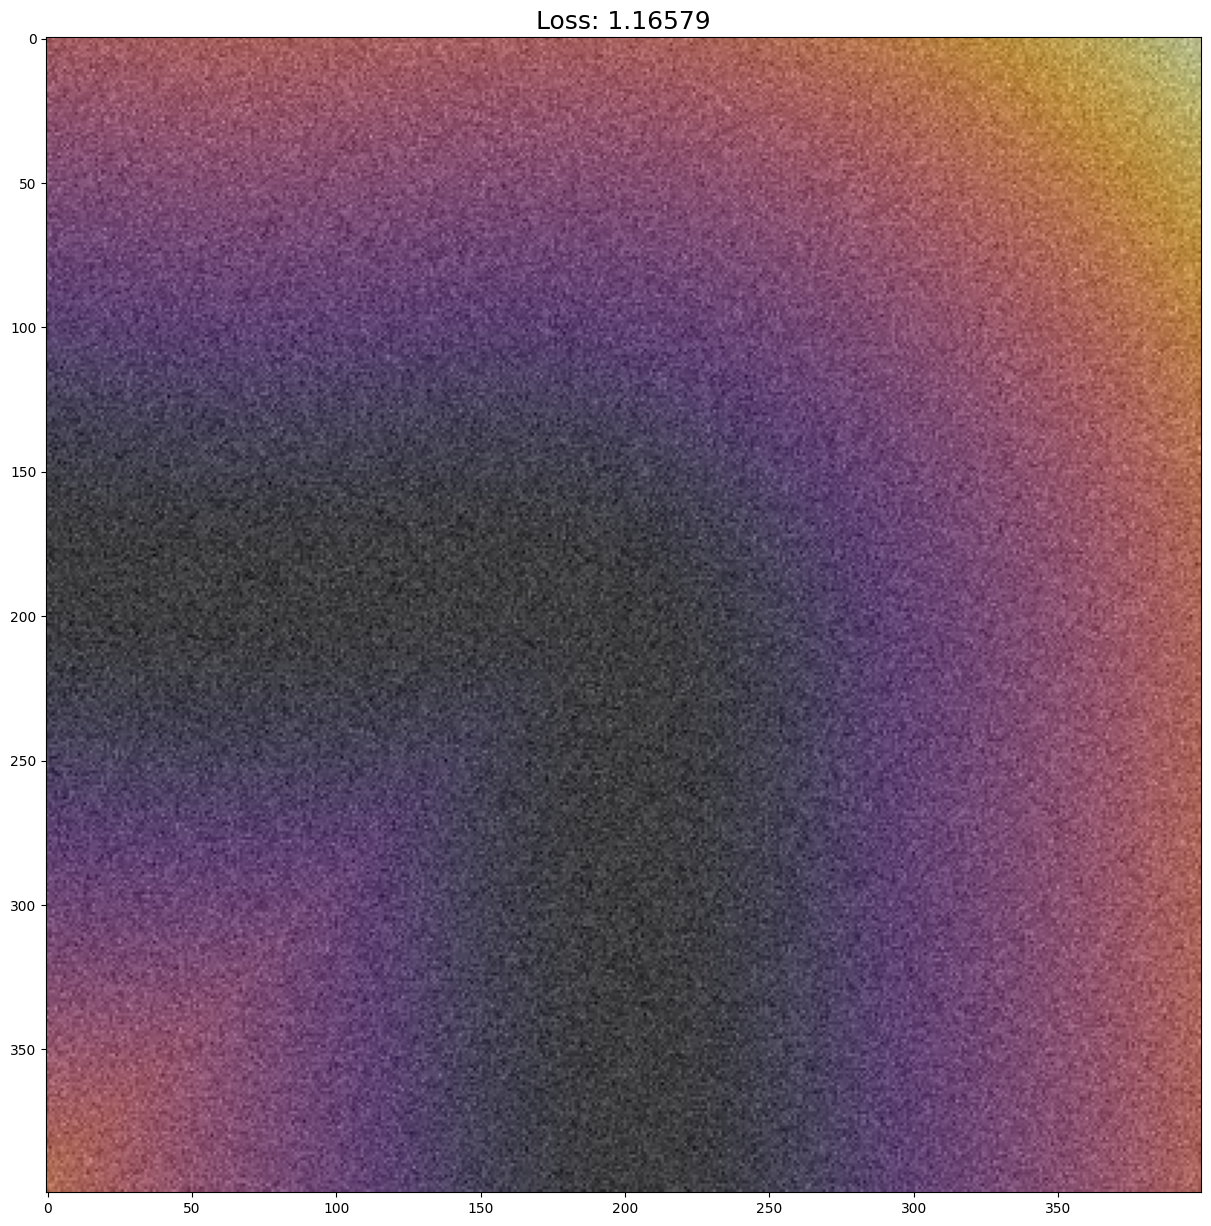

In [13]:
lc = ll.ColdMapLoss()

fig, axs = plt.subplots(1, 1, figsize=(15, 15))

comps = ["./comps/comp1.png", "./comps/comp2.png", "./noise.png", "./comps/comp7.png", "./comps/comp8.png"] + [gt_path]

paths = [cv2.imread(c, cv2.IMREAD_GRAYSCALE) for c in comps]

_, binaries = zip(*[cv2.threshold(p, 1, 1, cv2.THRESH_BINARY) for p in paths])

binaries_t = [torch.from_numpy(b).float() for b in binaries]

# random tensor [1, 5, 400, 400]
noise = torch.randn(1, 5, 400, 400)

cmap_dim = cmap_t.unsqueeze(0).unsqueeze(0)

print(lc(cmap_dim, noise))


plt.imshow(cmap, cmap="inferno")
plt.imshow(noise[0, 0, :, :].detach().numpy(), cmap="gray", alpha=0.5)  # Select the first channel for visualization
plt.title(f"Loss: {lc(cmap_dim, noise).item():.5f}", fontsize=18)
# losses = [lc(cmap_t, b).unsqueeze(0).unsqueeze(0) for b in binaries_t]

# for i, (p, b, l) in enumerate(zip(paths, binaries, losses)):
#     axs[i // 3, i % 3].imshow(cmap, cmap="inferno")
#     axs[i // 3, i % 3].imshow(p, cmap="gray", alpha=0.5)
#     axs[i // 3, i % 3].set_title(f"Loss: {l:.5f}", fontsize=18)
#     axs[i // 3, i % 3].axis("off")

# fig.tight_layout()
# fig.subplots_adjust(hspace=0.08)

#fig.savefig("cmap_loss_comparison7.png", transparent=True)
#plt.savefig("loss_comparison.png")
plt.show()


In [ ]:
gt_path = "./intersection_001/paths/path_1/path_line.png"
gt_cmap = "./intersection_001/paths/path_1/cold_map.png"
test_path = "./comps/comp8.png"

l = ll.CmapLoss()

cmap_gt = cv2.imread(gt_cmap, cv2.IMREAD_GRAYSCALE)

path = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)
_, binary = cv2.threshold(path, 1, 1, cv2.THRESH_BINARY)

cmap2 = torch.from_numpy(cmap).float().requires_grad_(True)
cmap_f = torch.flatten(cmap2)

path_np = np.array(path)
path_t = torch.from_numpy(path_np).float().requires_grad_(True)
path_f = torch.flatten(path_t)

loss = l(cmap_f, path_f)
loss

## BCE

In [ ]:
def main():
    # Example usage
    ground_truth_path = "./intersection_001/paths/path_1/path_line.png"
    prediction_path = "./comps/comp5.png"
    
    try:
        loss = ll.bce_loss(ground_truth_path, prediction_path)
        print(f"BCE Loss: {loss:.6f}")
    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

comps = ["./comps/comp2.png", "./comps/comp3.png", "./comps/comp4.png", "./comps/comp5.png", "./comps/comp6.png", "./comps/comp7.png", "./comps/comp8.png"] + [gt_path]

paths = [cv2.imread(c, cv2.IMREAD_GRAYSCALE) for c in comps]

_, binaries = zip(*[cv2.threshold(p, 1, 1, cv2.THRESH_BINARY) for p in paths])

#losses = [ll.cmap_loss(cmap, b) for b in binaries]
losses = [ll.bce_loss(gt_path, b, "mean") for b in comps]

names = ["a", "b", "c", "d", "e", "f", "g", "h"]

for i, (p, b, l, n) in enumerate(zip(paths, binaries, losses, names)):
    t = paths[-1] + p
    t = cv2.cvtColor(t, cv2.COLOR_GRAY2BGR)
    axs[i // 4, i % 4].imshow(paths[-1], cmap="inferno")
    axs[i // 4, i % 4].imshow(p, cmap="gray", alpha=0.5)
    #axs[i // 4, i % 4].imshow(t, cmap="gray", alpha=1)
    
    axs[i // 4, i % 4].set_title(f"({n}) Loss: {l:.2f}", fontsize=18)
    axs[i // 4, i % 4].axis("off")

fig.tight_layout()
fig.subplots_adjust(hspace=0.08)

#fig.savefig("cmap_loss_comparison4.png", transparent=True)
#plt.savefig("loss_comparison.png")
plt.show()



In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

gt_path = "./intersection_001/paths/path_1/path_line.png"
gt_cmap = "./intersection_001/paths/path_1/cold_map.png"
test_path = "./comps/comp1.png"

ground_truth_img = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
prediction_img = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)

ground_truth = ground_truth_img / 255.0
prediction = prediction_img / 255.0

gt_tensor = torch.from_numpy(ground_truth).float()
p_tensor = torch.from_numpy(prediction).float()

print(f"{gt_tensor.shape=}, {p_tensor.shape=}")

gt_tensor_u1 = gt_tensor.unsqueeze(0)
p_tensor_u1 = p_tensor.unsqueeze(0)

print(f"{gt_tensor_u1.shape=}, {p_tensor_u1.shape=}")

gt_tensor_u2 = gt_tensor_u1.unsqueeze(0)
p_tensor_u2 = p_tensor_u1.unsqueeze(0)

print(f"{gt_tensor_u2.shape=}, {p_tensor_u2.shape=}")


In [ ]:
l = torch.nn.BCELoss()

l0 = l(gt_tensor, p_tensor)
l1 = l(gt_tensor_u1, p_tensor_u1)
l2 = l(gt_tensor_u2, p_tensor_u2)

print(f"{l0=}, {l1=}, {l2=}")

## Topology (old)
*Finally, the last part of the loss function will deal with the actual topology of the predicted path. It will heavily penalize breaks in the path, branches in paths, and other topological errors, such as not reaching connecting the entry and exit.*

In [ ]:
import torch
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt
from PIL import Image


def load_image_as_tensor(image_path):
    """
    Loads an image from disk, converts it to grayscale, normalizes to [0, 1],
    and returns it as a torch.Tensor.
    """
    image = Image.open(image_path).convert('L')  # convert to grayscale
    image_np = np.array(image, dtype=np.float32)
    # Normalize to [0, 1] if the image is in [0, 255]
    image_np = image_np / 255.0
    return torch.tensor(image_np, dtype=torch.float32)

def get_persistence_diagram(image_tensor, homology_dim=0):
    """
    Compute the persistence diagram for a 2D image using a cubical complex.
    
    Args:
        image_tensor (torch.Tensor): a 2D tensor (H x W) representing the image.
        homology_dim (int): homology dimension to extract (0 for connected components, 1 for loops, etc.)
    
    Returns:
        diag (np.ndarray): an array of [birth, death] pairs for the chosen homology,
                           with infinite intervals removed.
    """
    # Convert the PyTorch tensor to a numpy array.
    img = image_tensor.cpu().detach().numpy()
    
    img_inv = 1.0 - img
    
    # Create a cubical complex from the inverted image.
    cc = gd.CubicalComplex(top_dimensional_cells=img_inv)
    cc.persistence()
    
    # Extract the persistence intervals for the chosen homology dimension.
    diag = np.array(cc.persistence_intervals_in_dimension(homology_dim))
    # Remove any intervals with infinite values to avoid NaNs.
    if diag.size > 0:
        diag = diag[np.isfinite(diag).all(axis=1)]
    return diag

def diagram_distance(pd1, pd2):
    """
    Compute a simple distance between two persistence diagrams.
    (For each point in pd1, we take the minimal Euclidean distance to any point in pd2, and then sum these.)
    
    Args:
        pd1 (np.ndarray): array of [birth, death] pairs (shape: N x 2)
        pd2 (np.ndarray): array of [birth, death] pairs (shape: M x 2)
    
    Returns:
        distance (float): a scalar distance between the two diagrams.
    """
    # If either diagram is empty, we can define the distance as zero.
    if len(pd1) == 0 or len(pd2) == 0:
        return 0.0
    distance = 0.0
    for point in pd1:
        dists = np.linalg.norm(pd2 - point, axis=1)
        distance += np.min(dists)
    return distance

def topological_loss(pred, gt, homology_dim=0):
    """
    Compute a topological loss as the distance between the persistence diagrams of
    the predicted likelihood map and the ground truth binary path.
    
    Args:
        pred (torch.Tensor): predicted likelihood map (H x W) with values in [0, 1].
        gt (torch.Tensor): ground truth binary path (H x W).
        homology_dim (int): homology dimension for persistence (0, 1, etc.)
    
    Returns:
        loss (torch.Tensor): a scalar loss.
    """
    # Compute persistence diagrams for the predicted and ground truth images.
    pd_pred = get_persistence_diagram(pred, homology_dim)
    pd_gt   = get_persistence_diagram(gt, homology_dim)
    
    # Compute a simple distance between the diagrams.
    loss_value = diagram_distance(pd_pred, pd_gt)
    
    # Wrap the loss value into a torch tensor.
    loss = torch.tensor(loss_value, dtype=torch.float32, requires_grad=True)
    return loss

def plot_image(image, title):
    """
    Plot a 2D image.
    """
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.show()

def plot_persistence_diagram(pd, title):
    """
    Plot a persistence diagram.
    """
    plt.figure()
    if len(pd) > 0:
        plt.scatter(pd[:, 0], pd[:, 1], color='blue', marker='o', label='Persistence Points')
        # Plot the diagonal
        min_val = min(np.min(pd[:, 0]), np.min(pd[:, 1]))
        max_val = max(np.max(pd[:, 0]), np.max(pd[:, 1]))
        plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='Diagonal')
    plt.xlabel("Birth")
    plt.ylabel("Death")
    plt.title(title)
    plt.legend()
    plt.show()

# === Main execution ===
if __name__ == "__main__":
    # === Variables for the image file paths ===
    input_path_image_path = "./comps/comp12.png"
    gt_path_image_path    = "./intersection_001/paths/path_1/path_line.png"

    
    # Load images from disk as torch tensors.
    pred = load_image_as_tensor(input_path_image_path)
    gt   = load_image_as_tensor(gt_path_image_path)
    
    # Plot the input images.
    plot_image(pred.cpu().numpy(), "Predicted Likelihood Map")
    plot_image(gt.cpu().numpy(), "Ground Truth Path")
    
    # Compute persistence diagrams for both images.
    pd_pred = get_persistence_diagram(pred, homology_dim=0)
    pd_gt = get_persistence_diagram(gt, homology_dim=0)
    
    # Plot the persistence diagrams.
    plot_persistence_diagram(pd_pred, "Persistence Diagram: Predicted")
    plot_persistence_diagram(pd_gt, "Persistence Diagram: Ground Truth")
    
    a = np.concatenate([pd_pred, pd_gt])
    
    plot_persistence_diagram(a, "Persistence Diagram: Combined")
    
    # Calculate the topological loss.
    loss = topological_loss(pred, gt, homology_dim=0)
    print("Topological Loss:", loss.item())


In [ ]:
import torchvision.models as models
from topoloss import TopoLoss, LaplacianPyramid

model = models.resnet34(weights = "DEFAULT")

topo_loss = TopoLoss(
    losses = [
        LaplacianPyramid.from_layer(
            model=model,
            layer = model.fc, ## layer to apply topoloss on
            factor_h=8.0,
            factor_w=8.0,
            scale = 1.0  ## strength, equivalent to "tau" in the paper
        ),
    ],
)
t_loss = topo_loss.compute(model=model) ## add this to your training loss during training!

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

gt_path = "./intersection_001/paths/path_1/path_line.png"
gt_cmap = "./intersection_001/paths/path_1/cold_map.png"
test_path = "./comps/comp1.png"

ground_truth_img = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
prediction_img = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)

ground_truth = ground_truth_img / 255.0
prediction = prediction_img / 255.0

gt_tensor = torch.from_numpy(ground_truth).float()
p_tensor = torch.from_numpy(prediction).float()

bce_loss = ll.bce_loss_torch(gt_tensor, p_tensor)
print(f"BCE Loss: {bce_loss:.6f}")

In [ ]:
total_loss = bce_loss + t_loss
print(f"Total Loss: {total_loss:.6f}")

total_loss.backward()

In [ ]:
import torch

# Define your optimizer with the model parameters
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Set a weighting factor for the topo loss if needed
lambda_topo = 0.1

# Training loop
for i in range(1000):
    optimizer.zero_grad()  # zero the gradients
    
    # forward pass
    

    # Compute the losses
    t_loss = topo_loss.compute(model=model)
    bce_loss = ll.bce_loss_torch(gt_tensor, p_tensor)

    # Combine the losses (apply lambda if needed)
    total_loss = bce_loss + lambda_topo * t_loss

    # Backpropagation and optimizer step
    total_loss.backward()
    optimizer.step()

    # Print losses every 100 iterations (or adjust the frequency)
    if i % 100 == 0:
        print(f"Iteration {i}: BCE loss = {bce_loss.item():.4f}, Topo loss = {t_loss.item():.4f}, Total loss = {total_loss.item():.4f}")
        
model.fc


# Topology Loss
## Continuity

In [ ]:
if __name__ == "__main__":
    test_path = "./comps/comp9.png"
    prediction = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)

    p_tensor = torch.from_numpy(prediction).float().requires_grad_(True)

    # Define target Betti numbers (e.g., 1 connected component, 0 holes).
    target_betti = {0: 1, 1: 0}

    # Initialize the persistent homology loss module.
    topo_loss_fn = ll.PersistentHomologyLoss(target_betti, threshold=0.75)

    # Compute the loss using the prediction tensor.
    loss = topo_loss_fn(p_tensor)
    print("Topological Loss:", loss.item())
    print("grad_fn:", loss.grad_fn)


In [ ]:
import matplotlib.pyplot as plt
import cv2

gt_path = "./intersection_001/paths/path_1/path_line.png"
save_base_path = "./topo_cont_plots/"

test_paths = [gt_path] + ["./comps/comp7.png", "./comps/comp9.png", "./comps/comp13.png"] # + [f"./lines/lines{i}.png" for i in range(1, 3)]
alph = ["a", "b", "c", "d", "e", "f", "g", "h"]

t = 0.75

# Create a figure with subplots
fig, axs = plt.subplots(1, 4, figsize=(14, 4.5))
fig.suptitle(f"Topological Loss for Different Predictions (Threshold = {t})", fontsize=20)

# Define target Betti numbers
target_betti = {0: 1, 1: 0}
topo_loss_fn = ll.PersistentHomologyLoss(target_betti, threshold=t)

# Process each image
for i, test_path in enumerate(test_paths):
    # Load and preprocess image
    prediction = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)
    #prediction_blur = cv2.GaussianBlur(prediction, (5, 5), 0)
    #prediction_norm = prediction / 255.0
    p_tensor = torch.from_numpy(prediction).float().requires_grad_(True)
    
    # Calculate topological loss
    loss = topo_loss_fn(p_tensor)
    
    # Plot in the right subplot position
    #row, col = i // 4, i % 4
    axs[i].imshow(prediction, cmap='gray')
    axs[i].set_title(f'({alph[i]}) Loss: {loss.item():.4f}', fontsize=16)
    axs[i].axis('off')

fig.tight_layout(rect=[0, 0, 1, 0.99])
fig.savefig(f"{save_base_path}topo_loss_plots_report2.png", transparent=True)
plt.show()

## Branching

In [ ]:
target_ee = 2

test_path = "./comps/comp7.png"
prediction = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)
p_tensor = torch.from_numpy(prediction).float().requires_grad_(True)

endpoints_loss_fn = ll.EndpointsLoss(target_ee)

loss = endpoints_loss_fn(p_tensor)
loss

In [ ]:
import matplotlib.pyplot as plt
import cv2

importlib.reload(ll)
importlib.reload(dl)

gt_path = "./intersection_001/paths/path_1/path_line.png"
save_base_path = "./topo_bran_plots/"

test_paths = [gt_path] + ["./comps/comp8.png", "./comps/comp7.png", "./comps/comp10.png", "./comps/comp1.png"] 
alph = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]

# Create a figure with subplots
fig, axs = plt.subplots(5, 4, figsize=(16, 20))

a = 50.0
t = 0.8
branching_fn = ll.EndpointsLoss(target_ee, alpha=a, threshold=t)

slopes = [30, 40, 50, 60, 70]
ts = [0.75, 0.8, 0.85, 0.9]

gt_path = "./intersection_001/paths/path_1/path_line.png"
test_path = "./comps/comp7.png"
prediction = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)
p_tensor = torch.from_numpy(prediction).float().requires_grad_(True)

from matplotlib.lines import Line2D

for i in range(0, 5):
    for j in range(0, 4):
        branching_fn = ll.EndpointsLoss(target_ee, alpha=slopes[i], threshold=ts[j])
        loss = branching_fn(p_tensor)
        axs[i, j].imshow(prediction, cmap='gray')
        #axs[i, j].set_title(f"Loss: {loss.item():.1f}", fontsize=16)
        legend_elements = [Line2D([0], [0], marker='o', color='w', alpha=0.0, linewidth=0.0, label=f"Alpha: {slopes[i]}"),
                           Line2D([0], [0], marker='o', color='w', alpha=0.0, linewidth=0.0, label=f"Threshold: {ts[j]}"),
                           Line2D([0], [0], marker='o', color='w', alpha=0.0, linewidth=0.0, label=f"Loss: {loss.item():.1f}")
                           ]
        axs[i, j].legend(handles=legend_elements, prop={'size': 14}, loc='upper right')
        axs[i, j].axis('off')
        
    
cv2.destroyAllWindows()

fig.tight_layout()
fig.savefig(f"{save_base_path}branching_loss_plots_appendix.png", transparent=True)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import cv2

gt_path = "./intersection_001/paths/path_1/path_line.png"
save_base_path = "./topo_bran_plots/"

test_paths = [gt_path] + ["./comps/comp7.png", "./comps/comp8.png", "./comps/comp11.png"] # + [f"./lines/lines{i}.png" for i in range(1, 3)]
alph = ["a", "b", "c", "d", "e", "f", "g", "h"]

t = 0.85

# Create a figure with subplots
fig, axs = plt.subplots(1, 4, figsize=(14, 4.5))

branching_fn = ll.EndpointsLoss(target_ee)

# Process each image
for i, test_path in enumerate(test_paths):
    # Load and preprocess image
    prediction = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)
    #prediction_blur = cv2.GaussianBlur(prediction, (5, 5), 0)
    #prediction_norm = prediction / 255.0
    p_tensor = torch.from_numpy(prediction).float().requires_grad_(True)
    
    # Calculate topological loss
    loss = branching_fn(p_tensor)
    
    # Plot in the right subplot position
    #row, col = i // 4, i % 4
    axs[i].imshow(prediction, cmap='gray')
    axs[i].set_title(f'({alph[i]}) Loss: {loss.item():.4f}', fontsize=16)
    axs[i].axis('off')

fig.tight_layout(rect=[0, 0, 1, 0.99])
#fig.savefig(f"{save_base_path}branch_loss_plots_report.png", transparent=True)
plt.show()

## Entry and Exit

# Combine

In [ ]:
import torchvision.models as models

model = models.resnet34(weights="DEFAULT")

In [ ]:
gt_path = "./intersection_001/paths/path_1/path_line.png"
gt_cmap = "./intersection_001/paths/path_1/cold_map.png"
test_path = "./comps/comp8.png"

lc = ll.CmapLoss(1/1000)

cmap_gt = cv2.imread(gt_cmap, cv2.IMREAD_GRAYSCALE)

path = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)
_, binary = cv2.threshold(path, 1, 1, cv2.THRESH_BINARY)

cmap2 = torch.from_numpy(cmap).float().requires_grad_(True)
cmap_f = torch.flatten(cmap2)

path_np = np.array(path)
path_t = torch.from_numpy(path_np).float().requires_grad_(True)
path_f = torch.flatten(path_t)


L_cmap = lc(cmap_f, path_f)

In [ ]:
L_cmap

In [ ]:
gt_path = "./intersection_001/paths/path_1/path_line.png"
gt_cmap = "./intersection_001/paths/path_1/cold_map.png"
test_path = "./comps/comp1.png"

lb = ll.BCELoss()

ground_truth_img = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
prediction_img = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)

ground_truth = ground_truth_img / 255.0
prediction = prediction_img / 255.0

gt_tensor = torch.from_numpy(ground_truth).float()
p_tensor = torch.from_numpy(prediction).float().requires_grad_(True)


L_bce = lb(gt_tensor, p_tensor)

In [ ]:
L_bce